# Imports

In [ ]:
from pathlib import Path
from pprint import pprint
from typing import Any, Dict, Tuple
from datetime import datetime

import numpy as np
import pandas as pd
from scipy.io import loadmat

from main import Weather
from main import Soil

Array = np.ndarray



DATA_PATH = Path("data")

# Utility helpers

In [ ]:
# -----------------------------
# Utility helpers
# -----------------------------
def load_matlab_file_as_dict(filename: str, verbose=False) -> Dict[str, Any]:
    loaded_dict: Dict[str, Any] = loadmat(DATA_PATH / "Soil" / filename)
    if verbose:
        pprint(loaded_dict.keys())
    return loaded_dict


def load_weather(path: Path, start_date: datetime, end_date: datetime) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["FECHA"] = pd.to_datetime(df["FECHA"], format="%Y-%m-%d")
    df.rename(
        columns={
            "FECHA": "scene_date",
            "TMPMED": "temp",
            "RAD": "par",
            "PREC": "precip",
            "ET0": "et0",
        },
        inplace=True,
    )
    cols = ["scene_date", "temp", "par", "precip", "et0"]
    df = df.loc[
        (df["scene_date"] >= start_date) & (df["scene_date"] <= end_date),
        cols,
    ]
    return df


# -----------------------------
# Loaders
# -----------------------------
def load_soil_from_data() -> Tuple[Array, Array, Array, Array, Array, Array]:
    mask_maize: Array = load_matlab_file_as_dict("mat_maiz_2021_lowres.mat")[
        "clase_maiz_2021_lowres"
    ]
    lat: Array = load_matlab_file_as_dict("mat_maiz_2021_lat_lowres.mat")["lat_lowres"]
    lon: Array = load_matlab_file_as_dict("mat_maiz_2021_lon_lowres.mat")["lon_lowres"]
    dds0: Array = load_matlab_file_as_dict("mat_dds_maiz_est_lowres.mat")["dds_est"]
    water0: Array = (
        load_matlab_file_as_dict("mat_aguadisp_saocom_maiz_2021-2022_2.mat")[
            "a_disp_campo"
        ]
        / 100.0
    )  # Si water0 es entre (0,1) hay que dividir. Pregungar a jero. Porcentaje de agua util.
    mask_soy = np.zeros_like(mask_maize)
    return (mask_maize, mask_soy, lat, lon, dds0, water0)


def load_weather_from_data(
    data_path: Path, start_time: datetime, end_time: datetime
) -> Tuple[
    Array,
    Array,
    Array,
    Array,
]:
    df_weather: pd.DataFrame = load_weather(data_path, start_time, end_time)
    temp, par, precip, et0 = (
        df_weather["temp"].to_numpy(),
        df_weather["par"].to_numpy(),
        df_weather["precip"].to_numpy(),
        df_weather["et0"].to_numpy(),
    )
    return temp, par, precip, et0

# Load weather DataFrame

In [ ]:
DATA_PATH = Path("data")
start_date = datetime(2021, 12, 4)
end_date = datetime(2022, 6, 2)

data_path = Path(DATA_PATH, "Weather", "weather.csv")

df_weather = load_weather(data_path, start_date, end_date)

# Run simulation

## Set parameters

In [ ]:
# -----------------------------
# Set parameters from data files
# -----------------------------
start_date = datetime(2021, 12, 4)
end_date = datetime(2022, 6, 1)

WEATHER_CSV_PATH = Path(DATA_PATH, "Weather", "weather.csv")

mask_maize, mask_soy, lat, lon, dds0, water0 = load_soil_from_data()
temp, par, precip, et0 = load_weather_from_data(WEATHER_CSV_PATH, start_date, end_date)

# -----------------------------
# Initialize Soil model
# -----------------------------
weather = Weather(
    temp=temp,
    par=par,
    precip=precip,
    et0=et0,
)

soil = Soil(
    mask_maize=mask_maize,
    mask_soy=mask_soy,
    lat=lat,
    lon=lon,
    water0=water0,
    dds0=dds0,
)

## Evolve system

In [ ]:
target_crop = "maize"
results = soil.evolve(target_crop, weather)

In [ ]:
import matplotlib.pyplot as plt

result_yield = results.yield_
tile_yield = [result_yield[::, day].sum() for day in results.dates]
plt.plot(results.dates, tile_yield)

In [ ]:
biomass_daily = [results.biomass_daily[::, day].sum() for day in results.dates]
plt.plot(results.dates, biomass_daily)

In [ ]:
biomass_cum = [results.biomass_cum[::, day].sum() for day in results.dates]
plt.plot(results.dates, biomass_cum)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML

rc("animation", html="jshtml")  # clave para que se renderice en la celda

data = results.biomass_daily  # (nx, ny, T)
print(data.shape)
T = data.shape[-1]

vmin = np.nanmin(data)
vmax = np.nanmax(data)
print(vmin, vmax)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(data[:, :, 0], origin="lower", vmin=vmin, vmax=vmax, cmap="YlGn")
cbar = plt.colorbar(im, ax=ax, label="Yield")
ax.set_title("Yield evolution - Maize (t=0)")


def update(t):
    im.set_array(data[:, :, t])
    ax.set_title(f"Evolution - Maize (t={t})")
    return [im]


ani = animation.FuncAnimation(fig, update, frames=T, interval=180, blit=True)

HTML(ani.to_jshtml())

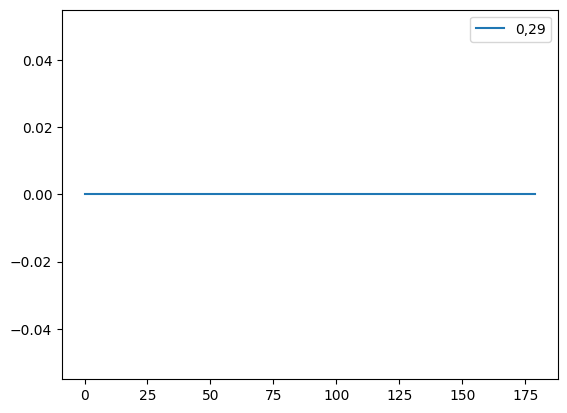

In [78]:
soil.mask_maize[1, 0]
found = False
for i in range(soil.mask_maize.shape[0]):
    for j in range(soil.mask_maize.shape[1]):
        if soil.mask_maize[i, j]:
            plt.plot(results.dates, results.yield_[i, j, :], label=f"{i},{j}")
            plt.legend()
            found = True
            break
    if found:
        break